In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
from diffusers import StableDiffusionPipeline

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA A100-PCIE-40GB'

In [4]:
import sys
print(sys.executable)

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/gen_valid/bin/python


# Prompt2MedImage

In [13]:
model_id = "Nihirc/Prompt2MedImage"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

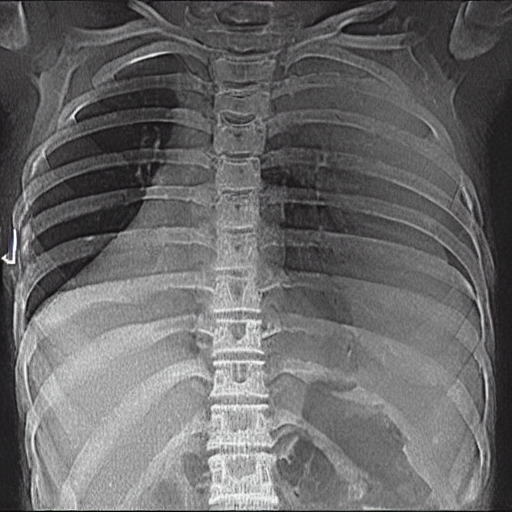

In [19]:
prompt = "big left-sided pleural effusion"
image = pipe(prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

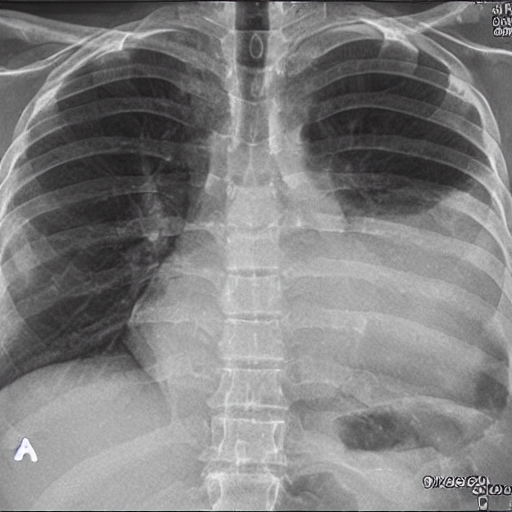

In [18]:
prompt = "small left-sided pleural effusion"
image = pipe(prompt).images[0]
image

# RoentGen

In [6]:
model_path = "roentgen"
device = "cuda" 

pipe = StableDiffusionPipeline.from_pretrained(model_path).to(torch.float32).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/data/healthy-ml/scratch/qixuanj/anaconda3/envs/gen_valid/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

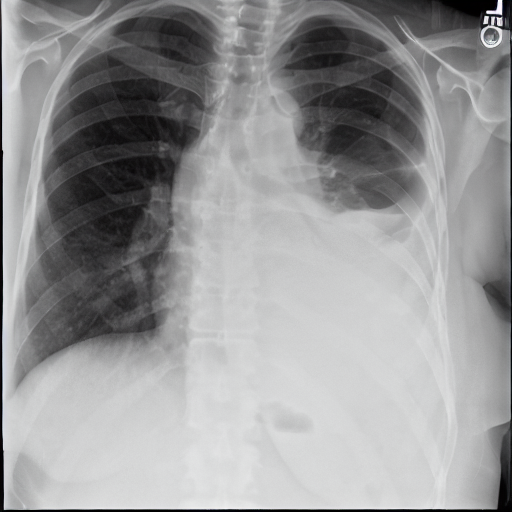

In [11]:
prompt = "big left-sided pleural effusion"

output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4)
output.images[0]

  0%|          | 0/75 [00:00<?, ?it/s]

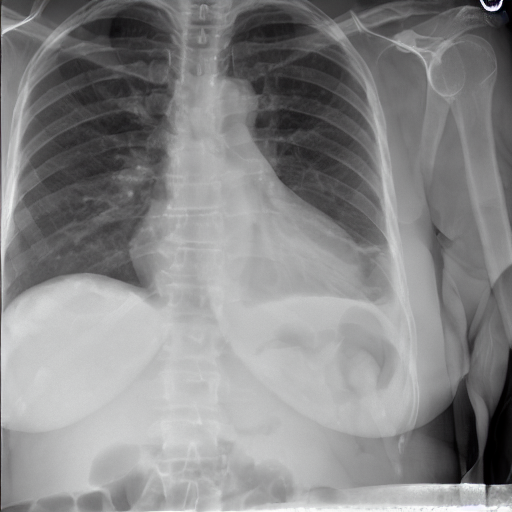

In [7]:
prompt = "small left-sided pleural effusion"

output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4)
output.images[0]

# TorchXRayVision Validation

In [40]:
import torchxrayvision as xrv
import skimage, torch, torchvision

In [230]:
def normalize_image(image): 
    img = xrv.datasets.normalize(np.array(image), 255)
    img = img.mean(2)[None, ...]
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)
    return img

def predict_for_image(model, image): 
    img = normalize_image(image)
    outputs = model(img[None,...]) # or model.features(img[None,...]) 
    
    # Print results
    return dict(zip(model.pathologies,outputs[0].detach().numpy()))

## Individual Image

  0%|          | 0/75 [00:00<?, ?it/s]

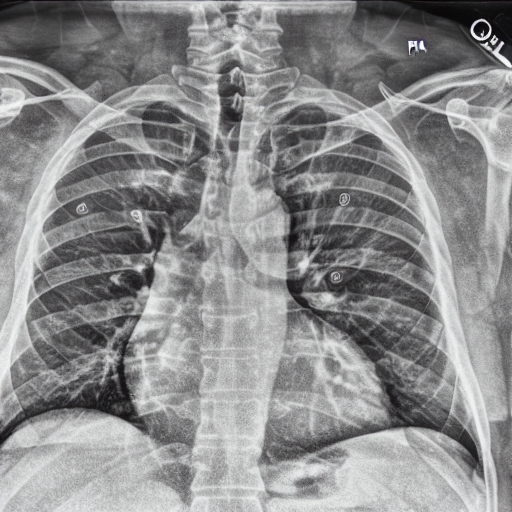

In [357]:
output = pipe(["enlarged cardiomediastinum"], num_inference_steps=75, height=512, width=512, guidance_scale=4)
image = output.images[0]
image

In [359]:
results = predict_for_image(model, image)
results

{'Atelectasis': 0.2758079,
 'Consolidation': 0.40976113,
 'Infiltration': 0.5088329,
 'Pneumothorax': 0.5150354,
 'Edema': 0.29778695,
 'Emphysema': 0.5003734,
 'Fibrosis': 0.038598668,
 'Effusion': 0.12123612,
 'Pneumonia': 0.51275593,
 'Pleural_Thickening': 0.014418425,
 'Cardiomegaly': 0.52281857,
 'Nodule': 0.50108325,
 'Mass': 0.519351,
 'Hernia': 0.0011011006,
 'Lung Lesion': 0.43328735,
 'Fracture': 0.5475074,
 'Lung Opacity': 0.5201135,
 'Enlarged Cardiomediastinum': 0.6252841}

In [360]:
seg_model = xrv.baseline_models.chestx_det.PSPNet()
with torch.no_grad():
    pred = seg_model(normalize_image(image))

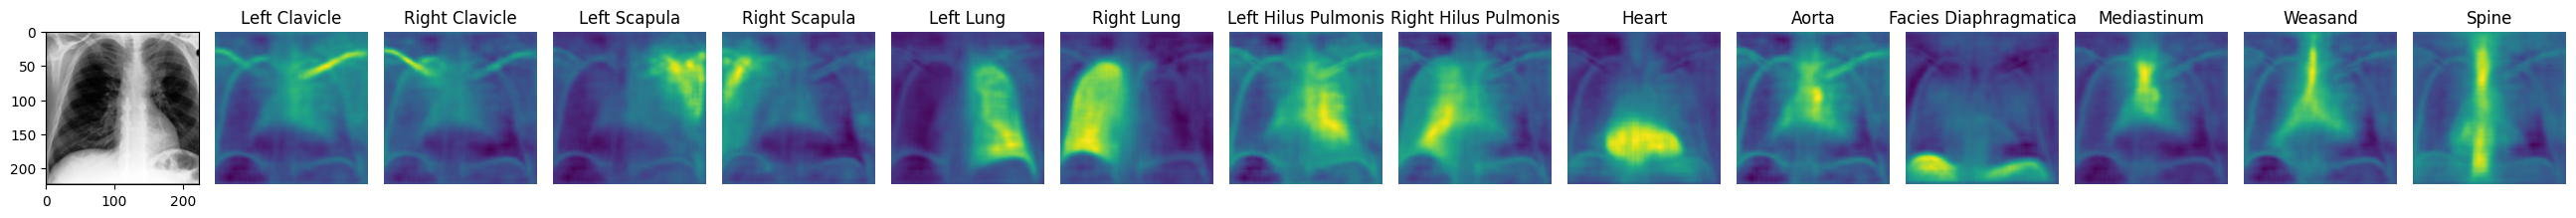

In [361]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(seg_model.targets) + 1, 1)
plt.imshow(img[0], cmap='gray')
for i in range(len(seg_model.targets)):
    plt.subplot(1, len(seg_model.targets) + 1, i+2)
    plt.imshow(pred[0, i])
    plt.title(seg_model.targets[i])
    plt.axis('off')
plt.tight_layout()

In [362]:
pred = 1 / (1 + np.exp(-pred))  # sigmoid
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1

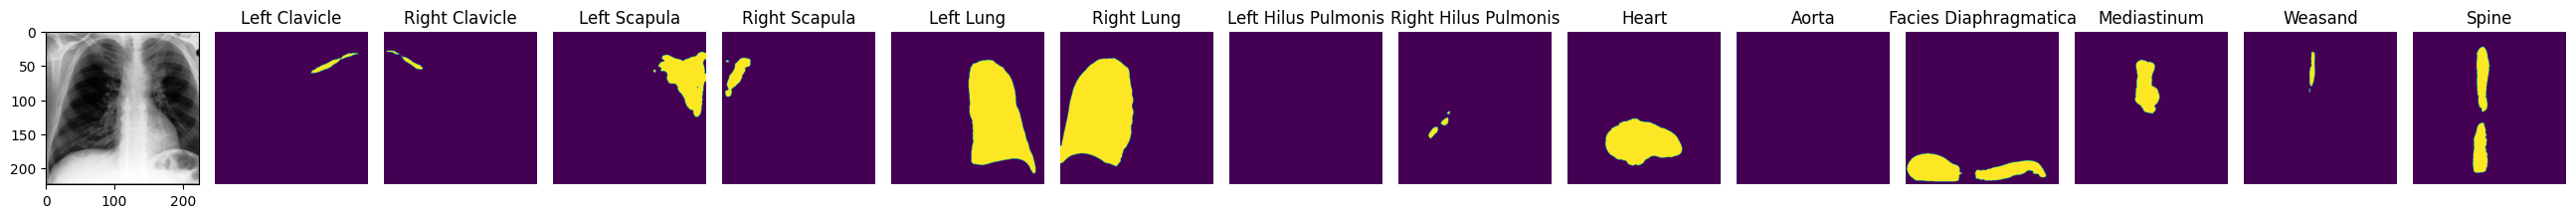

In [363]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(seg_model.targets) + 1, 1)
plt.imshow(img[0], cmap='gray')
for i in range(len(seg_model.targets)):
    plt.subplot(1, len(seg_model.targets) + 1, i+2)
    plt.imshow(pred[0, i])
    plt.title(seg_model.targets[i])
    plt.axis('off')
plt.tight_layout()

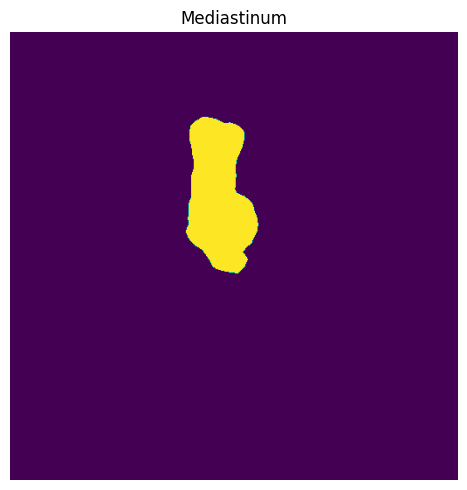

In [364]:
i = 11
plt.figure(figsize = (26,5))
plt.imshow(pred[0, i])
plt.title(seg_model.targets[i])
plt.axis('off')
plt.tight_layout()

In [365]:
(pred[0, 11].sum().numpy() / torch.numel(pred[0, 11]))

0.03899383544921875

## Group Evaluation

In [114]:
for i, t in enumerate(seg_model.targets): 
    print("{}: {}".format(i, t))

0: Left Clavicle
1: Right Clavicle
2: Left Scapula
3: Right Scapula
4: Left Lung
5: Right Lung
6: Left Hilus Pulmonis
7: Right Hilus Pulmonis
8: Heart
9: Aorta
10: Facies Diaphragmatica
11: Mediastinum
12: Weasand
13: Spine


In [282]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")

prompts = ["no finding", "normal mediastinum", "enlarged mediastinum", "enlarged cardiomediastinum"]
# prompts = ["no finding", "no cardiomegaly", "cardiomegaly", "enlarged heart"]
num_repeats = 20

df_classifier_pred = pd.DataFrame(index = list(range(num_repeats)), columns = prompts)
df_perc_segment = pd.DataFrame(index = list(range(num_repeats)), columns = prompts)

for p in prompts: 
    for j in range(num_repeats):
        output = pipe([p], num_inference_steps=75, height=512, width=512, guidance_scale=4)
        image = output.images[0]
        results = predict_for_image(model, image)
        df_classifier_pred.loc[j, p] = results['Enlarged Cardiomediastinum']
        # df_classifier_pred.loc[j, p] = results['Cardiomegaly']
        
        with torch.no_grad():
            prediction = seg_model(normalize_image(image))
        prediction = 1 / (1 + np.exp(-prediction))  # sigmoid
        prediction[prediction < 0.5] = 0
        prediction[prediction > 0.5] = 1
        df_perc_segment.loc[j, p] = (prediction[0, 11].sum().numpy() / torch.numel(prediction[0, 11]))
        # df_perc_segment.loc[j, p] = (prediction[0, 8].sum().numpy() / torch.numel(prediction[0, 8]))

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [283]:
df_classifier_pred.mean(axis=0)

no finding                    0.457124
normal mediastinum            0.096992
enlarged mediastinum          0.269387
enlarged cardiomediastinum    0.389531
dtype: object

In [284]:
df_classifier_pred_binary = pd.DataFrame(np.where(df_classifier_pred > 0.5, 1, 0), columns = df_classifier_pred.columns)

In [285]:
df_classifier_pred_binary.mean(axis=0)

no finding                    0.70
normal mediastinum            0.15
enlarged mediastinum          0.25
enlarged cardiomediastinum    0.60
dtype: float64

In [290]:
feature = 'no finding'
# print(roc_auc_score(np.zeros(len(df_classifier_pred)), df_classifier_pred[feature]))
print(accuracy_score(np.zeros(len(df_classifier_pred)), df_classifier_pred_binary[feature]))
print(recall_score(np.zeros(len(df_classifier_pred)), df_classifier_pred_binary[feature]))
print(precision_score(np.zeros(len(df_classifier_pred)), df_classifier_pred_binary[feature]))

0.3
0.0
0.0


In [288]:
df_perc_segment_mean = df_perc_segment.mean(axis=0)

In [289]:
df_perc_segment_mean

no finding                    0.038837
normal mediastinum            0.047613
enlarged mediastinum          0.060906
enlarged cardiomediastinum    0.037778
dtype: object

# Sanity Check - Validation on Ground-Truth Images

In [14]:
import os
import glob
import skimage

In [ ]:
# Sanity check: actual chest x-ray images with enlarged mediastinum and without enlarged mediastinum have different ratios 

In [22]:
metadata = pd.read_csv("/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-metadata.csv.gz")

In [24]:
metadata.head()

dicom_id  subject_id  study_id  \
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1  174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267   
2  2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   
3  e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c    10000032  53189527   
4  68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714    10000032  53911762   

  PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate  \
0                CHEST (PA AND LAT)           PA  3056     2544   21800506   
1                CHEST (PA AND LAT)      LATERAL  3056     2544   21800506   
2                CHEST (PA AND LAT)           PA  3056     2544   21800626   
3                CHEST (PA AND LAT)      LATERAL  3056     2544   21800626   
4               CHEST (PORTABLE AP)           AP  2705     2539   21800723   

    StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning  \
0  213014.531                CHEST (PA AND LAT)             postero-anterior   
1  213014.531                CHEST (PA AND LAT)                      lateral   
2  165500.312                CHEST (PA AND LAT)             postero-anterior   
3  165500.312                CHEST (PA AND LAT)                      lateral   
4   80556.875               CHEST (PORTABLE AP)             antero-posterior   

  PatientOrientationCodeSequence_CodeMeaning  
0                                      Erect  
1                                      Erect  
2                                      Erect  
3                                      Erect  
4                                        NaN

In [27]:
# Get the most standard chest x-ray: PA Erect
metadata[metadata['ViewPosition'] == "PA"]["PatientOrientationCodeSequence_CodeMeaning"].value_counts()

PatientOrientationCodeSequence_CodeMeaning
Erect        81754
Recumbent    14099
Name: count, dtype: int64

In [29]:
meta = metadata[(metadata['ViewPosition'] == "PA") & (metadata['PatientOrientationCodeSequence_CodeMeaning'] == "Erect")]

In [37]:
meta['img_path'] = meta.apply(lambda row: 'p' + str(row['subject_id'])[:2] + '/p' + str(row['subject_id']) + \
                       '/s' + str(row['study_id']) + '/' + row['dicom_id'] + '.jpg', axis = 1)

/tmp/ipykernel_786453/42912437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['img_path'] = meta.apply(lambda row: 'p' + str(row['subject_id'])[:2] + '/p' + str(row['subject_id']) + \


In [38]:
meta['img_path'].iloc[0]

'p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg'

In [73]:
dir = '/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files/'
img = skimage.io.imread(dir + meta['img_path'].iloc[0])
img = xrv.datasets.normalize(np.array(img), 255)
print(img.shape)
img = np.expand_dims(img, axis = 0)
print(img.shape)
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
img = transform(img)
print(img.shape)
img = torch.from_numpy(img)

(3056, 2544)
(1, 3056, 2544)
(1, 224, 224)


In [75]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")
outputs = model(img[None,...])
outputs = dict(zip(model.pathologies, outputs[0].detach().numpy()))

In [76]:
outputs

{'Atelectasis': 0.09578165,
 'Consolidation': 0.17594936,
 'Infiltration': 0.52583134,
 'Pneumothorax': 0.19939809,
 'Edema': 0.037046276,
 'Emphysema': 0.5072131,
 'Fibrosis': 0.5239716,
 'Effusion': 0.042425267,
 'Pneumonia': 0.07935109,
 'Pleural_Thickening': 0.43573827,
 'Cardiomegaly': 0.07455742,
 'Nodule': 0.5640763,
 'Mass': 0.5131781,
 'Hernia': 0.0024876576,
 'Lung Lesion': 0.50345755,
 'Fracture': 0.28782734,
 'Lung Opacity': 0.41953593,
 'Enlarged Cardiomediastinum': 0.3092052}

In [89]:
# The labels 
labels = pd.read_csv("/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-negbio.csv.gz")

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


In [80]:
meta = pd.merge(meta, labels, left_on = ["subject_id", "study_id"], right_on = ["subject_id", "study_id"])

In [ ]:
labels

# Enlarged Cardiomediastinum

In [159]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score

In [262]:
pos = meta[meta['Enlarged Cardiomediastinum'] == 1]
neg = meta[meta['Enlarged Cardiomediastinum'] == 0]
neutral = meta[meta['Enlarged Cardiomediastinum'].isnull()]
print(len(pos))
print(len(neg))
print(len(neutral))

947
1734
78238


In [263]:
# 31395 remaining uncovered samples
print(len(meta))

81750


In [264]:
# All mutually exclusive 
print(len(np.intersect1d(pos.index, neutral.index)))
print(len(np.intersect1d(neg.index, neutral.index)))

0
0


In [267]:
pos_sample = pos.sample(n=100, replace=False)
neg_sample = neg.sample(n=100, replace=False)

In [268]:
cohort = pd.concat([pos_sample, neg_sample])

In [266]:
from tqdm import tqdm

In [269]:
# get the average prediction AUC for pos, neg, and neutral group 
model = xrv.models.DenseNet(weights="densenet121-res224-all")
pred_proba = []

for i in tqdm(range(len(cohort))): 
    img = skimage.io.imread(dir + cohort['img_path'].iloc[i])
    img = xrv.datasets.normalize(np.array(img), 255)
    img = np.expand_dims(img, axis = 0)
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)
    
    outputs = model(img[None,...])
    pred_proba.append(outputs[0].detach().numpy())
    
pred_proba = np.array(pred_proba)
pred = np.where(pred_proba > 0.5, 1, 0)

100%|███████████████████████████████████████████████████| 200/200 [01:32<00:00,  2.16it/s]


In [270]:
df_pred_proba = pd.DataFrame(pred_proba, columns = model.pathologies)
df_pred = pd.DataFrame(pred, columns = model.pathologies)

In [271]:
print(roc_auc_score(cohort['Enlarged Cardiomediastinum'], df_pred_proba['Enlarged Cardiomediastinum']))
print(accuracy_score(cohort['Enlarged Cardiomediastinum'], df_pred['Enlarged Cardiomediastinum']))
print(recall_score(cohort['Enlarged Cardiomediastinum'], df_pred['Enlarged Cardiomediastinum']))
print(precision_score(cohort['Enlarged Cardiomediastinum'], df_pred['Enlarged Cardiomediastinum']))

0.8132
0.745
0.65
0.8024691358024691


In [ ]:
# Segmentation check

In [272]:
for i, t in enumerate(seg_model.targets): 
    print("{}: {}".format(i, t))

0: Left Clavicle
1: Right Clavicle
2: Left Scapula
3: Right Scapula
4: Left Lung
5: Right Lung
6: Left Hilus Pulmonis
7: Right Hilus Pulmonis
8: Heart
9: Aorta
10: Facies Diaphragmatica
11: Mediastinum
12: Weasand
13: Spine


In [273]:
# Check and validate with the segmentation model 
df_perc_segment_pos = pd.DataFrame(index = list(range(len(pos_sample))), columns = ['Mediastinum'])

for i in tqdm(range(len(pos_sample))): 
    img = skimage.io.imread(dir + pos_sample['img_path'].iloc[i])
    img = xrv.datasets.normalize(np.array(img), 255)
    img = np.expand_dims(img, axis = 0)
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)

    with torch.no_grad():
        pred = seg_model(img)
    pred = 1 / (1 + np.exp(-pred))  # sigmoid
    pred[pred < 0.5] = 0
    pred[pred > 0.5] = 1
    df_perc_segment_pos.loc[i, 'Mediastinum'] = (pred[0, 11].sum().numpy() / torch.numel(pred[0, 11]))

100%|███████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


In [274]:
df_perc_segment_neg = pd.DataFrame(index = list(range(len(neg_sample))), columns = ['Mediastinum'])

for i in tqdm(range(len(neg_sample))): 
    img = skimage.io.imread(dir + neg_sample['img_path'].iloc[i])
    img = xrv.datasets.normalize(np.array(img), 255)
    img = np.expand_dims(img, axis = 0)
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)

    with torch.no_grad():
        pred = seg_model(img)
    pred = 1 / (1 + np.exp(-pred))  # sigmoid
    pred[pred < 0.5] = 0
    pred[pred > 0.5] = 1
    df_perc_segment_neg.loc[i, 'Mediastinum'] = (pred[0, 11].sum().numpy() / torch.numel(pred[0, 11]))

100%|███████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


In [279]:
print(df_perc_segment_pos.mean())
print(df_perc_segment_neg.mean())
print(df_perc_segment_pos.mean() - df_perc_segment_neg.mean())

Mediastinum    0.053864
dtype: object
Mediastinum    0.055347
dtype: object
Mediastinum   -0.001483
dtype: object


# Cardiomegaly

In [185]:
# 1 -> positive, 0 -> negative; -1 -> uncertain or ambiguous, nan -> not mentioned
pos = meta[meta['Cardiomegaly'] == 1]
neg = meta[meta['Cardiomegaly'] == 0]
neutral = meta[meta['Cardiomegaly'].isnull()]
print(len(pos))
print(len(neg))
print(len(neutral))

6107
4212
70022


In [186]:
# All mutually exclusive 
print(len(np.intersect1d(pos.index, neutral.index)))
print(len(np.intersect1d(neg.index, neutral.index)))

0
0


In [177]:
# Random sample for time reasons 
pos_sample = pos.sample(n=100, replace=False)
neg_sample = neg.sample(n=100, replace=False)

In [178]:
cohort = pd.concat([pos_sample, neg_sample])

In [179]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")

pred_proba = []
for i in tqdm(range(len(cohort))): 
    img = skimage.io.imread(dir + cohort['img_path'].iloc[i])
    img = xrv.datasets.normalize(np.array(img), 255)
    img = np.expand_dims(img, axis = 0)
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)
    
    outputs = model(img[None,...])
    pred_proba.append(outputs[0].detach().numpy())
    
pred_proba = np.array(pred_proba)
pred = np.where(pred_proba > 0.5, 1, 0)

100%|███████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


In [180]:
df_pred_proba = pd.DataFrame(pred_proba, columns = model.pathologies)
df_pred = pd.DataFrame(pred, columns = model.pathologies)

In [181]:
print(roc_auc_score(cohort['Cardiomegaly'], df_pred_proba['Cardiomegaly']))
print(accuracy_score(cohort['Cardiomegaly'], df_pred['Cardiomegaly']))
print(recall_score(cohort['Cardiomegaly'], df_pred['Cardiomegaly']))
print(precision_score(cohort['Cardiomegaly'], df_pred['Cardiomegaly']))

0.8865999999999999
0.81
0.88
0.7719298245614035


In [169]:
for i, t in enumerate(seg_model.targets): 
    print("{}: {}".format(i, t))

0: Left Clavicle
1: Right Clavicle
2: Left Scapula
3: Right Scapula
4: Left Lung
5: Right Lung
6: Left Hilus Pulmonis
7: Right Hilus Pulmonis
8: Heart
9: Aorta
10: Facies Diaphragmatica
11: Mediastinum
12: Weasand
13: Spine


In [182]:
df_perc_segment_pos = pd.DataFrame(index = list(range(len(pos_sample))), columns = ['Heart'])

for i in tqdm(range(len(pos_sample))): 
    img = skimage.io.imread(dir + pos_sample['img_path'].iloc[i])
    img = xrv.datasets.normalize(np.array(img), 255)
    img = np.expand_dims(img, axis = 0)
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)

    with torch.no_grad():
        prediction = seg_model(img)
    prediction = 1 / (1 + np.exp(-prediction))  # sigmoid
    prediction[prediction < 0.5] = 0
    prediction[prediction > 0.5] = 1
    df_perc_segment_pos.loc[i, 'Heart'] = (prediction[0, 8].sum().numpy() / torch.numel(prediction[0, 8]))

100%|███████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


In [183]:
df_perc_segment_neg = pd.DataFrame(index = list(range(len(neg_sample))), columns = ['Heart'])

for i in tqdm(range(len(neg_sample))): 
    img = skimage.io.imread(dir + neg_sample['img_path'].iloc[i])
    img = xrv.datasets.normalize(np.array(img), 255)
    img = np.expand_dims(img, axis = 0)
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)

    with torch.no_grad():
        prediction = seg_model(img)
    prediction = 1 / (1 + np.exp(-prediction))  # sigmoid
    prediction[prediction < 0.5] = 0
    prediction[prediction > 0.5] = 1
    df_perc_segment_neg.loc[i, 'Heart'] = (prediction[0, 8].sum().numpy() / torch.numel(prediction[0, 8]))

100%|███████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


In [184]:
print(df_perc_segment_pos.mean())
print(df_perc_segment_neg.mean())
print(df_perc_segment_pos.mean() - df_perc_segment_neg.mean())

Heart    0.104213
dtype: object
Heart    0.086737
dtype: object
Heart    0.017476
dtype: object


In [187]:
print(df_perc_segment_pos.median())
print(df_perc_segment_neg.median())
print(df_perc_segment_pos.median() - df_perc_segment_neg.median())

Heart    0.101433
dtype: object
Heart    0.083414
dtype: object
Heart    0.018019
dtype: object


In [193]:
print(df_perc_segment_pos.max())
print(df_perc_segment_neg.min())
print(df_perc_segment_pos.max() - df_perc_segment_neg.min())

Heart    0.178783
dtype: object
Heart    0.0
dtype: object
Heart    0.178783
dtype: object


In [210]:
pos_example = pos_sample.iloc[df_perc_segment_pos[(df_perc_segment_pos['Heart'] > df_perc_segment_pos.median().iloc[0] - 0.001) & 
                    (df_perc_segment_pos['Heart'] < df_perc_segment_pos.median().iloc[0] + 0.001)].index]

In [223]:
neg_example = pos_sample.iloc[df_perc_segment_neg[(df_perc_segment_neg['Heart'] > df_perc_segment_neg.median().iloc[0] - 0.001) & 
                    (df_perc_segment_neg['Heart'] < df_perc_segment_neg.median().iloc[0] + 0.001)].index]

In [224]:
# Particular image - median 
img = skimage.io.imread(dir + neg_example['img_path'].iloc[0])
img = xrv.datasets.normalize(np.array(img), 255)
img = np.expand_dims(img, axis = 0)
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
img = transform(img)
img = torch.from_numpy(img)

with torch.no_grad():
    prediction = seg_model(img)

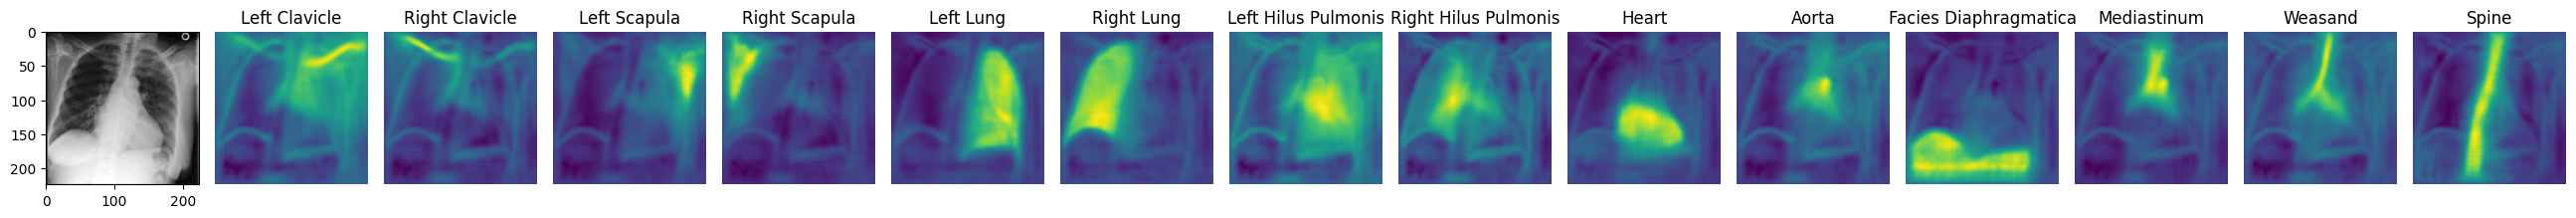

In [225]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(seg_model.targets) + 1, 1)
plt.imshow(img[0], cmap='gray')
for i in range(len(seg_model.targets)):
    plt.subplot(1, len(seg_model.targets) + 1, i+2)
    plt.imshow(prediction[0, i])
    plt.title(seg_model.targets[i])
    plt.axis('off')
plt.tight_layout()

In [226]:
prediction_binary = 1 / (1 + np.exp(-prediction))  # sigmoid
prediction_binary[prediction_binary < 0.5] = 0
prediction_binary[prediction_binary > 0.5] = 1

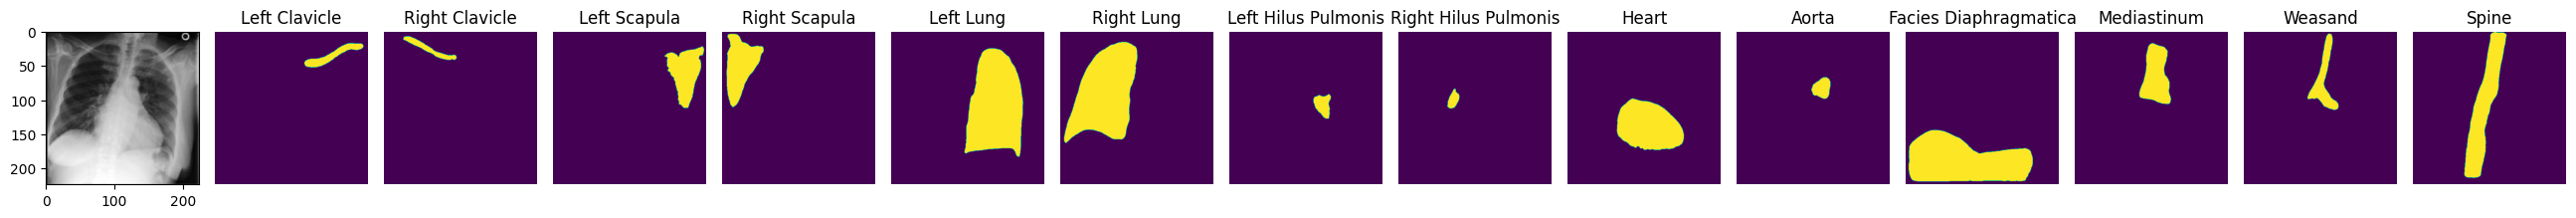

In [227]:
plt.figure(figsize = (26,5))
plt.subplot(1, len(seg_model.targets) + 1, 1)
plt.imshow(img[0], cmap='gray')
for i in range(len(seg_model.targets)):
    plt.subplot(1, len(seg_model.targets) + 1, i+2)
    plt.imshow(prediction_binary[0, i])
    plt.title(seg_model.targets[i])
    plt.axis('off')
plt.tight_layout()

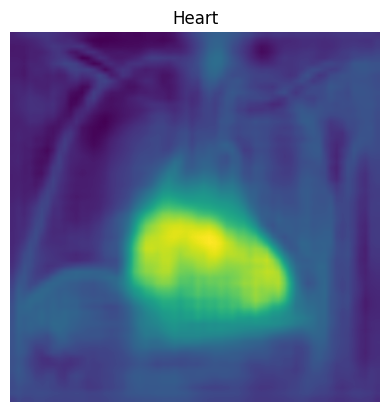

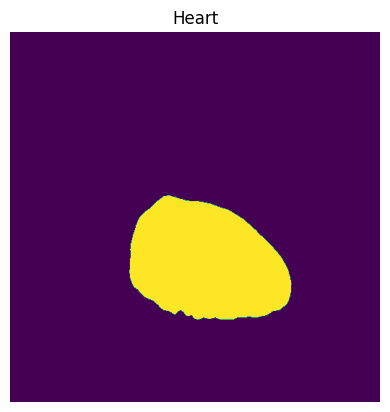

In [228]:
i = 8

plt.figure(figsize = (4,5))
plt.imshow(prediction[0, i])
plt.title(seg_model.targets[i])
plt.axis('off')
plt.tight_layout()

plt.figure(figsize = (4,5))
plt.imshow(prediction_binary[0, i])
plt.title(seg_model.targets[i])
plt.axis('off')
plt.tight_layout()

# General Prompt + Label Evaluation